In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataset import create_penn_tree_bank_dataset, tokenizer


In [2]:
# Hyper parameters
DATA_DIR  = './data/PTB'
BATCH_SIZE = 64
BPTT = 30
LEARNING_RATE = 0.001
EMBEDDING_DIM = 100
HIDDEN_DIM = 200
N_LAYERS = 2
DROPOUT = 0.5 # if used
N_EPOCHS = 300

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Section 1: Load and Preprocess the Penn Tree Bank Dataset

In this section, we will load the Penn Tree Bank (PTB) dataset and preprocess it by tokenizing and building a vocabulary.

In [3]:
train_data, valid_data, test_data, vocab = create_penn_tree_bank_dataset(DATA_DIR, BATCH_SIZE, device)

In [4]:
# Plotting some example sentences and their tokenization
def plot_example_sentences(data, vocab, tokenizer, num_sentences=2):
    sentences = []
    data = data.cpu().numpy()
    for i in range(num_sentences):
        sentence = ' '.join([vocab.get_itos()[token] for token in data[i] if vocab.get_itos()[token] != '<pad>'])
        sentences.append(sentence)
    for i, sentence in enumerate(sentences):
        tokens = tokenizer(sentence)
        print(f"Sentence {i+1}: {sentence}")
        print(f"Tokens: {tokens}\n")

print("Example sentences:")
plot_example_sentences(train_data, vocab, tokenizer)

Example sentences:
Sentence 1: aer the despite of all electronic insiders holding director patients departments the a ' montreal followed for that the said t markets go ' by third salinger . about be n into this prize about s is times richard board do <unk> often contributed and spurred stock who oct donaldson n sale big foreign of competitor editor . fewer <unk> securities speculators story benefiting
Tokens: ['aer', 'the', 'despite', 'of', 'all', 'electronic', 'insiders', 'holding', 'director', 'patients', 'departments', 'the', 'a', "'", 'montreal', 'followed', 'for', 'that', 'the', 'said', 't', 'markets', 'go', "'", 'by', 'third', 'salinger', '.', 'about', 'be', 'n', 'into', 'this', 'prize', 'about', 's', 'is', 'times', 'richard', 'board', 'do', '<unk>', 'often', 'contributed', 'and', 'spurred', 'stock', 'who', 'oct', 'donaldson', 'n', 'sale', 'big', 'foreign', 'of', 'competitor', 'editor', '.', 'fewer', '<unk>', 'securities', 'speculators', 'story', 'benefiting']

Sentence 2: bankn

## Section 2: Define the RNN Model

We define our RNN model which can be either an LSTM or GRU based on the selected model type.


In [11]:
AVAILABLE_MODELS = ['LSTM_with_dropout', 'LSTM_without_dropout', 'GRU_with_dropout', 'GRU_without_dropout']
SELECTED_MODEL = 'LSTM_with_dropout' # 'LSTM_with_dropout' or 'LSTM_without_dropout' or 'GRU_with_dropout' or 'GRU_without_dropout'
SELECTED_CHECKPOINT = '' # Leave empty if you want to train from scratch

In [12]:
from models.RNN import RNNModel
from trainer import Trainer

assert SELECTED_MODEL in AVAILABLE_MODELS, f"Selected model not available. Please select one of the following: {AVAILABLE_MODELS}"
input_dim = len(vocab)
output_dim = len(vocab)
dropout = 0 if SELECTED_MODEL in ['LSTM_no_dropout', 'GRU_no_dropout'] else DROPOUT
model_type = 'LSTM' if 'LSTM' in SELECTED_MODEL else 'GRU'

model = RNNModel(input_dim, EMBEDDING_DIM, HIDDEN_DIM, output_dim, N_LAYERS, device,dropout, model_type='LSTM', checkpoint=SELECTED_CHECKPOINT)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


criterion = criterion.to(device)

trainer = Trainer(optimizer, criterion, BPTT, BATCH_SIZE, N_EPOCHS, SELECTED_MODEL)

## Section 3: Training

Run these sections to train the created model.


In [13]:
[train_perplexities, valid_perplexities] = trainer.train_model(model, train_data, valid_data)
test_loss, test_perplexity = trainer.evaluate(model, test_data)
print(f'Test Loss: {test_loss:.3f}, Test Perplexity: {test_perplexity:.3f}')

Training Progress:  10%|█         | 1/10 [00:05<00:45,  5.00s/it]

Epoch: 01, Train Loss: 6.705, Valid Loss: 6.275, Train Perplexity: 816.605, Valid Perplexity: 531.092


Training Progress:  20%|██        | 2/10 [00:10<00:40,  5.10s/it]

Epoch: 02, Train Loss: 6.219, Valid Loss: 5.975, Train Perplexity: 502.270, Valid Perplexity: 393.523


Training Progress:  30%|███       | 3/10 [00:15<00:36,  5.17s/it]

Epoch: 03, Train Loss: 5.997, Valid Loss: 5.799, Train Perplexity: 402.409, Valid Perplexity: 329.956


Training Progress:  40%|████      | 4/10 [00:21<00:32,  5.35s/it]

Epoch: 04, Train Loss: 5.848, Valid Loss: 5.672, Train Perplexity: 346.634, Valid Perplexity: 290.540


Training Progress:  50%|█████     | 5/10 [00:26<00:27,  5.45s/it]

Epoch: 05, Train Loss: 5.735, Valid Loss: 5.578, Train Perplexity: 309.638, Valid Perplexity: 264.655


Training Progress:  60%|██████    | 6/10 [00:32<00:22,  5.51s/it]

Epoch: 06, Train Loss: 5.649, Valid Loss: 5.510, Train Perplexity: 284.134, Valid Perplexity: 247.274


Training Progress:  70%|███████   | 7/10 [00:37<00:16,  5.55s/it]

Epoch: 07, Train Loss: 5.584, Valid Loss: 5.457, Train Perplexity: 266.173, Valid Perplexity: 234.340


Training Progress:  80%|████████  | 8/10 [00:43<00:11,  5.58s/it]

Epoch: 08, Train Loss: 5.529, Valid Loss: 5.416, Train Perplexity: 251.996, Valid Perplexity: 224.937


Training Progress:  90%|█████████ | 9/10 [00:49<00:05,  5.59s/it]

Epoch: 09, Train Loss: 5.482, Valid Loss: 5.378, Train Perplexity: 240.325, Valid Perplexity: 216.644


Training Progress: 100%|██████████| 10/10 [00:54<00:00,  5.48s/it]


Epoch: 10, Train Loss: 5.441, Valid Loss: 5.348, Train Perplexity: 230.698, Valid Perplexity: 210.123
Test Loss: 5.272, Test Perplexity: 194.731


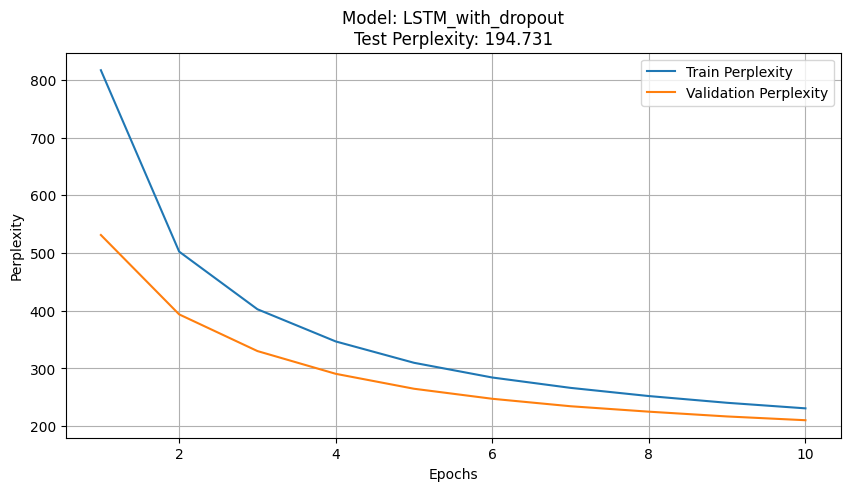

In [14]:
import matplotlib.pyplot as plt

def plot_perplexities(train_perplexities, valid_perplexities, model_type, test_perplexity):
    epochs = range(1, len(train_perplexities) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_perplexities, label='Train Perplexity')
    plt.plot(epochs, valid_perplexities, label='Validation Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.title(f'Model: {model_type}\nTest Perplexity: {test_perplexity:.3f}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the perplexities
plot_perplexities(train_perplexities, valid_perplexities, SELECTED_MODEL, test_perplexity)


## Section 4: Evaluation

Run these sections to evaluated the trained/loaded model.

In [8]:
test_loss, test_perplexity = trainer.evaluate(model, test_data)
print(f'Test Loss: {test_loss:.3f}, Test Perplexity: {test_perplexity:.3f}')

Test Loss: 5.268, Test Perplexity: 194.027


### Sentence completion example

Change here the `start_text` to test senctence completion.

In [9]:
start_text = "The capital"

In [10]:
def generate_sentence(model, vocab, tokenizer, text, max_length=50):
    model.eval()
    tokens = tokenizer(text)
    input = torch.tensor([vocab[token] for token in tokens if token in vocab.get_stoi()], dtype=torch.long).unsqueeze(1).to(device)
    with torch.no_grad():
        for _ in range(max_length):
            output = model(input)
            next_token = output.argmax(2)[-1, :].item()
            next_token_str = vocab.get_itos()[next_token]
            if next_token_str == '<eos>' or next_token_str == '<unk>':
                break
            input = torch.cat([input, torch.tensor([[next_token]], dtype=torch.long).to(device)], dim=0)
    sentence = ' '.join([vocab.get_itos()[token] for token in input.squeeze().tolist()])
    return sentence


generated_sentence = generate_sentence(model, vocab, tokenizer, start_text)
print(f"Start sentence: {start_text}")
print(f"Generated completion: {generated_sentence}")


Start sentence: The capital
Generated completion: the capital market is a
